# Vehicle loan default predection

Importing necessary libs and custom functions.

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RepeatedStratifiedKFold
from sklearn.metrics import classification_report
import shap
import numpy as np

#importing custom functions from functions.py file
from functions import dateconvert
from functions import yrscalc
from functions import time_diff_months
from functions import resample
from functions import model_perf
from functions import shapTree_plot
import pickle

In [52]:
df = pd.read_csv(r'../Data/train.csv')
df.head()

UniqueID  disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
0    420825             50578       58400  89.55         67        22807   
1    537409             47145       65550  73.23         67        22807   
2    417566             53278       61360  89.63         67        22807   
3    624493             57513       66113  88.48         67        22807   
4    539055             52378       60300  88.39         67        22807   

   manufacturer_id  Current_pincode_ID Date.of.Birth Employment.Type  ...  \
0               45                1441      01-01-84        Salaried  ...   
1               45                1502      31-07-85   Self employed  ...   
2               45                1497      24-08-85   Self employed  ...   
3               45                1501      30-12-93   Self employed  ...   
4               45                1495      09-12-77   Self employed  ...   

  SEC.SANCTIONED.AMOUNT  SEC.DISBURSED.AMOUNT  PRIMARY.INSTAL.AMT  \
0                     0                     0                   0   
1                     0                     0                1991   
2                     0                     0                   0   
3                     0                     0                  31   
4                     0                     0                   0   

   SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  AVERAGE.ACCT.AGE  \
0                                    0         0yrs 0mon   
1                                    1        1yrs 11mon   
2                                    0         0yrs 0mon   
3                                    0         0yrs 8mon   
4                                    0         0yrs 0mon   

   CREDIT.HISTORY.LENGTH  NO.OF_INQUIRIES  loan_default  
0              0yrs 0mon                0             0  
1             1yrs 11mon                0             1  
2              0yrs 0mon                0             0  
3              1yrs 3mon                1             1  
4              0yrs 0mon                1             1  

[5 rows x 41 columns]

We can see that employement type has NaN values, columns like Date of Birth annd Loan Disbursal are strings rather than date type.
So we mark NaN as 'unknown' and we use a custom function that uses pendulum to convert values to datetime.

In [53]:
df['Date.of.Birth'] = df['Date.of.Birth'].apply(dateconvert,delim='-')
df['DisbursalDate'] = df['DisbursalDate'].apply(dateconvert,delim='-')
df['Employment.Type'].fillna('Unknown',inplace=True)

Columns like Employment type, PERFORM_CNS.SCORE.DESCRIPTION have string values which we chnage to numeric to be fed into models.Columns like AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH have values like '2 yrs 4months'. We replace them with float values like 2.4 with a custom function yrscalc.

In [54]:
emp_type = {'Unknown':0,'Self employed':1,'Salaried':2}
cns_desc = {'No Bureau History Available':0,
            'Not Scored: Sufficient History Not Available':0,
            'Not Scored: Not Enough Info available on the customer':0,
           'Not Scored: No Activity seen on the customer (Inactive)':0,
           'Not Scored: No Updates available in last 36 months':0,
           'Not Scored: Only a Guarantor':1,
           'Not Scored: More than 50 active Accounts found':1,
           'M-Very High Risk':2,
           'L-Very High Risk':3,
           'K-High Risk':4,
            'J-High Risk':5,
            'H-Medium Risk':6,
            'I-Medium Risk':7,
            'F-Low Risk':8,
            'E-Low Risk':9,
            'G-Low Risk':10,
            'C-Very Low Risk':11,
            'A-Very Low Risk':12,
            'D-Very Low Risk':13,
            'B-Very Low Risk':14
           }
df['PERFORM_CNS.SCORE.DESCRIPTION'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].map(cns_desc)
df['Employment.Type'] = df['Employment.Type'].map(emp_type)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(yrscalc)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(yrscalc)

Creating new feature Age and Age of loan from DOB and loan loan disbursal date.We also combine ID proofs.Custom function is used to calculate the time delata value.The resultant value is an integer.

In [55]:
df['Age'] = df['Date.of.Birth'].apply(time_diff_months)
df['Age.of.Loan'] = df['DisbursalDate'].apply(time_diff_months)
df['No.of.Proofs'] = df[['Aadhar_flag','VoterID_flag','PAN_flag','Driving_flag','Passport_flag','MobileNo_Avl_Flag']].sum(axis=1)

All columns have been transformed to desired formats and new features created for better modeling.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 44 columns):
 #   Column                               Non-Null Count   Dtype                          
---  ------                               --------------   -----                          
 0   UniqueID                             233154 non-null  int64                          
 1   disbursed_amount                     233154 non-null  int64                          
 2   asset_cost                           233154 non-null  int64                          
 3   ltv                                  233154 non-null  float64                        
 4   branch_id                            233154 non-null  int64                          
 5   supplier_id                          233154 non-null  int64                          
 6   manufacturer_id                      233154 non-null  int64                          
 7   Current_pincode_ID                   233154 non-null  int64      

In [57]:
#lableling dependent column 'loan_default' for better readbility.
df['labels'] = df['loan_default'].apply(lambda x:'Paid' if x==0 else "default")

The dataset is imbalnced

In [58]:
fig = px.pie(df, names='labels')
fig.show()

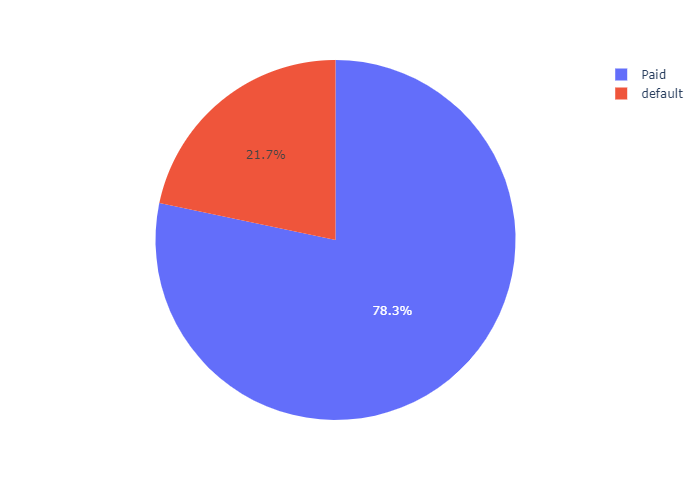

In [59]:
#code to reproduce plot for non dynamic render.
fig.write_image(r"../Images/imbalanced_data.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

Dropping rudimentary columns, and split the data for a seperate test set

In [60]:
X = df.drop(columns=['UniqueID','loan_default','labels','Date.of.Birth','DisbursalDate','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag','MobileNo_Avl_Flag'])
y = df[['loan_default']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=27)

We resample using SMOTE that we used in a custom function resample.Using feature importance attribute in ExtraTressClassifer we obtain feature scores.

In [61]:
os_X,os_y = resample(X_train,y_train,'minority')#resampling minority samples
etc_model = ExtraTreesClassifier(oob_score=True,random_state=27,bootstrap=True,n_estimators=15)
etc_model.fit(os_X,os_y)

C:\Users\kavin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning:

invalid value encountered in true_divide



ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
                     oob_score=True, random_state=27, verbose=0,
                     warm_start=False)

Creating a dataframe for a tubular column and sorting them in decending order.
We can see that features with secondary accounts have negligible. So we combine both primary and secondary account features.

In [62]:
columns = list(X_train.columns)
pd_feature = pd.DataFrame(data=[columns,etc_model.feature_importances_])
pd_feature = pd_feature.T
pd_feature.columns=['features','scores']
pd_feature.sort_values(['scores'],ascending=False)

features       scores
32                          Age.of.Loan     0.107498
2                                   ltv    0.0696107
6                    Current_pincode_ID    0.0676113
0                      disbursed_amount    0.0615972
3                             branch_id    0.0608833
31                                  Age    0.0608149
5                       manufacturer_id    0.0583106
1                            asset_cost    0.0566908
9                      Employee_code_ID    0.0560005
4                           supplier_id    0.0539476
8                              State_ID    0.0452856
7                       Employment.Type    0.0392082
10                    PERFORM_CNS.SCORE    0.0382055
11        PERFORM_CNS.SCORE.DESCRIPTION    0.0358712
28                     AVERAGE.ACCT.AGE    0.0186418
29                CREDIT.HISTORY.LENGTH    0.0185014
12                      PRI.NO.OF.ACCTS     0.016707
24                   PRIMARY.INSTAL.AMT    0.0153746
13                     PRI.ACTIVE.ACCTS    0.0153065
30                      NO.OF_INQUIRIES    0.0149673
17                 PRI.DISBURSED.AMOUNT    0.0144531
15                  PRI.CURRENT.BALANCE    0.0141576
16                PRI.SANCTIONED.AMOUNT     0.013883
26         NEW.ACCTS.IN.LAST.SIX.MONTHS    0.0116033
33                         No.of.Proofs    0.0109412
14                    PRI.OVERDUE.ACCTS   0.00864929
27  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS     0.006459
18                      SEC.NO.OF.ACCTS   0.00220028
22                SEC.SANCTIONED.AMOUNT   0.00123894
19                     SEC.ACTIVE.ACCTS   0.00122945
25                       SEC.INSTAL.AMT   0.00119358
23                 SEC.DISBURSED.AMOUNT   0.00118462
21                  SEC.CURRENT.BALANCE   0.00117648
20                    SEC.OVERDUE.ACCTS  0.000596058

Using bar chart to plot the feature scores

In [63]:
plt.figure(figsize=(25,25))
fig = px.bar(pd_feature,x='features',y='scores',text='scores', width=1000, height=700)
fig.update_layout(xaxis={'categoryorder':'total descending'},uniformtext_minsize=25)
fig.show()

<Figure size 1800x1800 with 0 Axes>

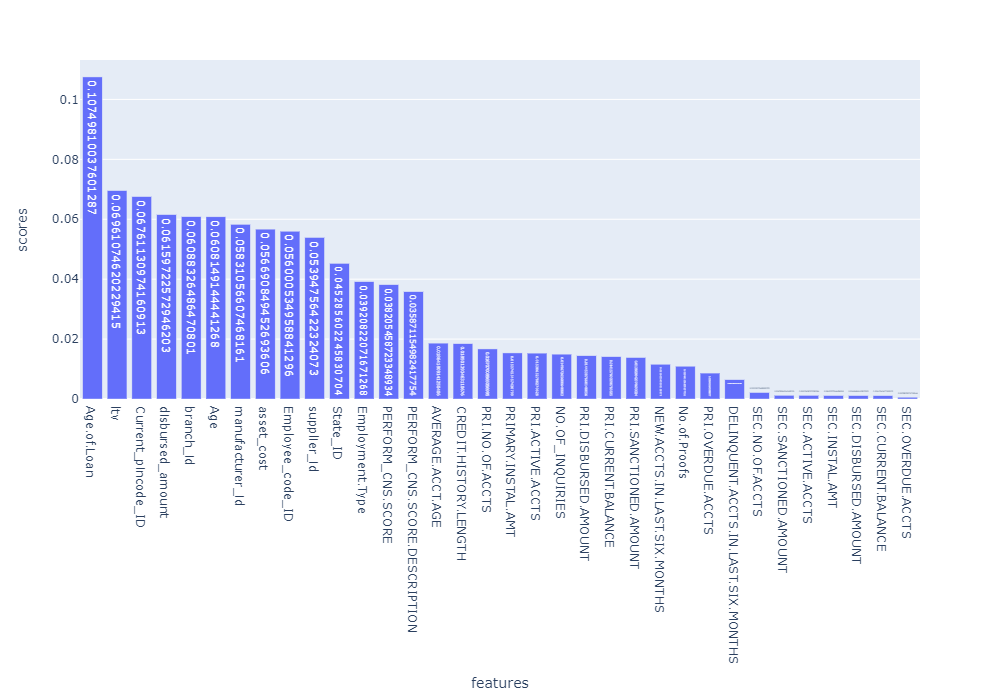

In [64]:
#non dynamic render.For purpose of being displayed in Github
fig.write_image(r"../Images/feature_score_before_clubbing.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

we could see that the secondary account features dont contribute much. We will combanie them with the primary account features.

In [65]:
df['Total.ACCTS'] = df[['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS']].sum(axis=1)
df['Total.Active.ACCTS'] = df[['PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS']].sum(axis=1)
df['Total.Overdue.ACCTS'] = df[['PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS']].sum(axis=1)
df['Total.CurrentBalance'] = df[['PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE']].sum(axis=1)
df['Total.SanctionedAmount'] = df[['PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT']].sum(axis=1)
df['Total.DisbursedAmount'] = df[['PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT']].sum(axis=1)
df['Total.InstalAmount'] = df[['PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']].sum(axis=1)

In [66]:
#dropping rcolumns that we have combained and reassigning values
X = df.drop(columns=['UniqueID','loan_default','labels','Date.of.Birth','DisbursalDate','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag','MobileNo_Avl_Flag','PRI.NO.OF.ACCTS',
                    'SEC.NO.OF.ACCTS','PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS','PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE',
                    'PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT'])
y = df[['loan_default']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=27)
os_X,os_y = resample(X_train,y_train,'minority')
os_X_test,os_y_test = resample(X_test,y_test,'minority')

In [67]:
#renaming columns
os_X.rename(columns={'Employment.Type':'Employment_Type','PERFORM_CNS.SCORE':'PERFORM_CNS_SCORE','PERFORM_CNS.SCORE.DESCRIPTION':'PERFORM_CNS_SCORE_DESCRIPTION','NEW.ACCTS.IN.LAST.SIX.MONTHS':'NEW_ACCTS_IN_LAST_SIX_MONTHS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS':'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
                    'AVERAGE.ACCT.AGE':'AVERAGE_ACCT_AGE','CREDIT.HISTORY.LENGTH':'CREDIT_HISTORY_LENGTH',
                           'NO.OF_INQUIRIES':'NO_OF_INQUIRIES','Age.of.Loan':'Age_of_Loan','No.of.Proofs':'No_of_Proofs',
                           'Total.ACCTS':'Total_ACCTS','Total.Active.ACCTS':'Total_Active_ACCTS','Total.Overdue.ACCTS':'Total_Overdue_ACCTS',
                           'Total.CurrentBalance':'Total_CurrentBalance','Total.SanctionedAmount':'Total_SanctionedAmount',
                           'Total.DisbursedAmount':'Total_DisbursedAmount','Total.InstalAmount':'Total_InstalAmount'},inplace=True)

In [68]:
os_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273596 entries, 0 to 273595
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   disbursed_amount                     273596 non-null  int64  
 1   asset_cost                           273596 non-null  int64  
 2   ltv                                  273596 non-null  float64
 3   branch_id                            273596 non-null  int64  
 4   supplier_id                          273596 non-null  int64  
 5   manufacturer_id                      273596 non-null  int64  
 6   Current_pincode_ID                   273596 non-null  int64  
 7   Employment_Type                      273596 non-null  int64  
 8   State_ID                             273596 non-null  int64  
 9   Employee_code_ID                     273596 non-null  int64  
 10  PERFORM_CNS_SCORE                    273596 non-null  int64  
 11  PERFORM_CNS_S

In [69]:
#resampling and assign DataFrame for better readability
etc_model = ExtraTreesClassifier(oob_score=True,random_state=27,bootstrap=True,n_estimators=15)
etc_model.fit(os_X,os_y.loan_default)
columns = list(os_X.columns)
pd_feature = pd.DataFrame(data=[columns,etc_model.feature_importances_])
pd_feature = pd_feature.T
pd_feature.columns=['features','scores']
pd_feature.sort_values(['scores'],ascending=False)

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning:

invalid value encountered in true_divide



features      scores
18                          Age_of_Loan     0.12651
2                                   ltv   0.0710042
6                    Current_pincode_ID   0.0660469
17                                  Age   0.0603547
0                      disbursed_amount   0.0598681
5                       manufacturer_id   0.0580528
3                             branch_id   0.0559598
1                            asset_cost   0.0554859
9                      Employee_code_ID   0.0554483
4                           supplier_id   0.0538187
8                              State_ID   0.0451065
10                    PERFORM_CNS_SCORE    0.041046
7                       Employment_Type   0.0368544
11        PERFORM_CNS_SCORE_DESCRIPTION   0.0353381
15                CREDIT_HISTORY_LENGTH   0.0188447
14                     AVERAGE_ACCT_AGE   0.0185703
20                          Total_ACCTS   0.0167697
16                      NO_OF_INQUIRIES   0.0152152
21                   Total_Active_ACCTS    0.014941
26                   Total_InstalAmount   0.0148727
24               Total_SanctionedAmount   0.0138292
25                Total_DisbursedAmount   0.0136992
23                 Total_CurrentBalance   0.0136044
12         NEW_ACCTS_IN_LAST_SIX_MONTHS   0.0114257
19                         No_of_Proofs   0.0109057
22                  Total_Overdue_ACCTS  0.00914541
13  DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS  0.00728252

In [70]:
plt.figure(figsize=(25,25))
fig = px.bar(pd_feature,x='features',y='scores',text='scores', width=1000, height=700)
fig.update_layout(xaxis={'categoryorder':'total descending'},uniformtext_minsize=25)
fig.show()

<Figure size 1800x1800 with 0 Axes>

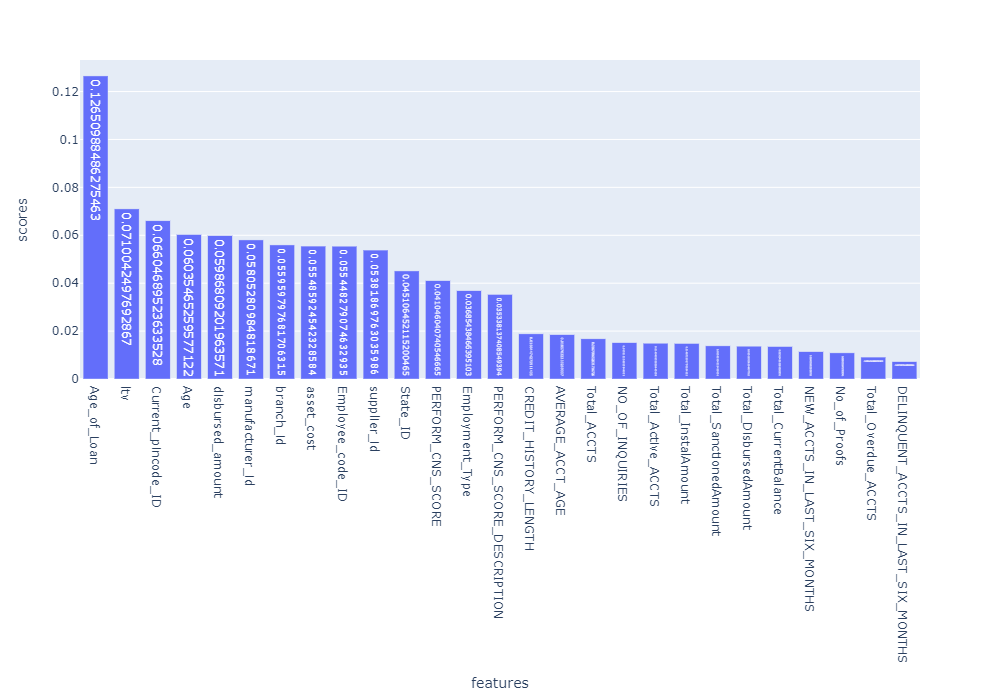

In [71]:
#non dynamic render.For purpose of being displayed in Github
fig.write_image(r"../Images/feature_score_after_clubbing.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

We will now analyze certain ensemble models randomforest and gradientboosting, primarily becasue they dont make any oridnal assumptions for numerical values and also are robust to outliers as well as scaling problems.

    Other methods include:
    1.We use GridSearchCV to identify best params
    2.Metric used is precision and recall
    3.We emply classification report to gather performance metrics

For computational limit we omit max_depth param for GradientBoosting

We pass grid params and choose precision as refit

In [ ]:
# using a custom fucnction that has code for GridSearchCV. Returns best_params_ and best_score_
gridient_params = [{'loss':['deviance', 'exponential'],'learning_rate':[0.3,0.5,0.7,0.9],'n_estimators':[50,100,150]}]
model_perf(GradientBoostingClassifier(),gridient_params,['precision','recall'],'precision',os_X,os_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.3min


In [ ]:
rand_prams= [{'n_estimators':[100,200,450,650,850],'max_depth':[5,7,15],'criterion':['gini','entropy']}]
model_perf(RandomForestClassifier(),rand_prams,['precision','recall'],'precision',os_X,os_y)# using a custom fucnction that has code for GridSearchCV

The results show that GradientBoosting is significantly better than RandomForest.We will tune params and generate a classification report

In [72]:
gbc_model = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',random_state=10,n_estimators=150)
gbc_model.fit(os_X,os_y.loan_default)
y_pred = gbc_model.predict(os_X_test)
c_report = classification_report(os_y_test.loan_default,y_pred,target_names=['Paid','Default'])
print(c_report)

              precision    recall  f1-score   support

        Paid       0.77      0.95      0.85     45745
     Default       0.93      0.72      0.81     45745

    accuracy                           0.83     91490
   macro avg       0.85      0.83      0.83     91490
weighted avg       0.85      0.83      0.83     91490



We got a faily good model that predicts loan default on first EMI payment

Its also important to know what caused the model arrive at class a given inputs as to if the person will pay or default. To do this SHAP library is used.Summary plot is used to get a overall idea.

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported 

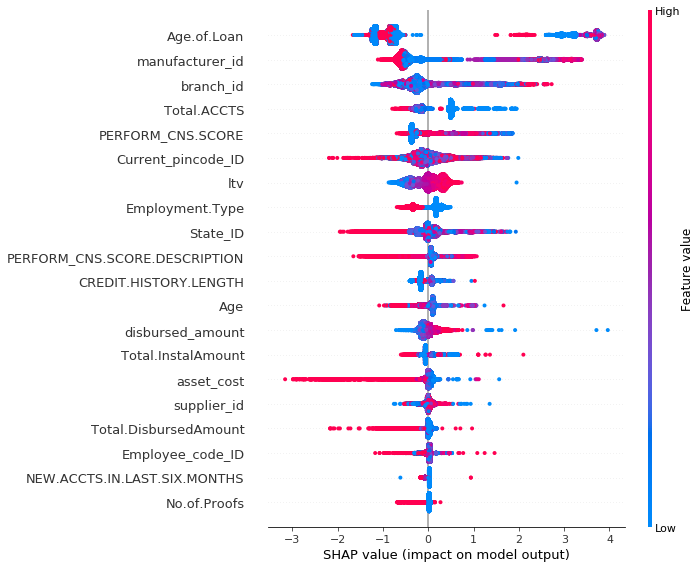

In [73]:
shap.initjs()
explainer = shap.TreeExplainer(gbc_model)
shap_values = explainer.shap_values(os_X_test)
shap.summary_plot(shap_values, features=os_X_test, feature_names=os_X_test.columns)

We go with the top 5 features here to get an understanding.

    1.Age.of.Loan - This one has 2 extremes where certain high and low values either decrease or increase prediction.A manual investigation is needed to find the cause.
    2.manufacturer_id - Here mainly high values decrease prediction while low and mid-ranged values increase prediction.
    3.branch_id - Lower values either tend to decrease prediction or have a small positive effect while high and mid-ranged values increase prediction.
    4.Total.ACCTS - Lower values highly tend to increase the prediction of the model.
    5.PERFORM_CNS_SCORE - Certain low values and most high values decrease prediction while most lower values tend to increase prediction.

SHAP gives a decent picture but to get a deeper understanding its always better to manually investigate for extreme behaviours as we see in Age.of.Loan feature. 

In [74]:
#Saving the model and features
pickle.dump(gbc_model,open('vc_loan_modelv1.pickle','wb'))
features = os_X.columns
pickle.dump(features,open('features.pickle','wb'))